In [1]:
import os
import itertools
import matplotlib.pyplot as plt
import pandas as pd 
import pvlib
from pvlib import clearsky, atmosphere, solarposition
from pvlib.location import Location
from pvlib import tracking
from pvlib.bifacial.pvfactors import pvfactors_timeseries
from pvlib import temperature
from pvlib.pvsystem import PVSystem, FixedMount
from pvlib.location import Location
from pvlib.modelchain import ModelChain
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS

import time
from pvlib.iotools import read_tmy3
from matplotlib import rcParams


rcParams['figure.figsize'] = 30, 10
rcParams['lines.linewidth'] = 1.5

/Users/yaizabermudez/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
import numpy as np
from sklearn.metrics import mean_squared_error as MSE

In [3]:
import xgboost
from sklearn.ensemble import RandomForestRegressor

## Data

In [32]:
df = pd.read_csv('data/prod.csv', parse_dates=['Date'], index_col='Date')
df.index = pd.to_datetime(df.index, format ='%Y-%m-%d %H:%M:%S%z') 
df = df.resample('1H').mean().interpolate(method='time')
df = df.loc[df.index <= '2023-06-01']
real = df[' Production PV toiture instantanee reelle (kW)']

pred = pd.read_csv('data/pred_roof_cs_inverters.csv', parse_dates=['Unnamed: 0'], index_col='Unnamed: 0')
pred.index = pd.to_datetime(pred.index, format ='%Y-%m-%d %H:%M:%S%z') 
pred_ = pred.to_numpy()[:-1]


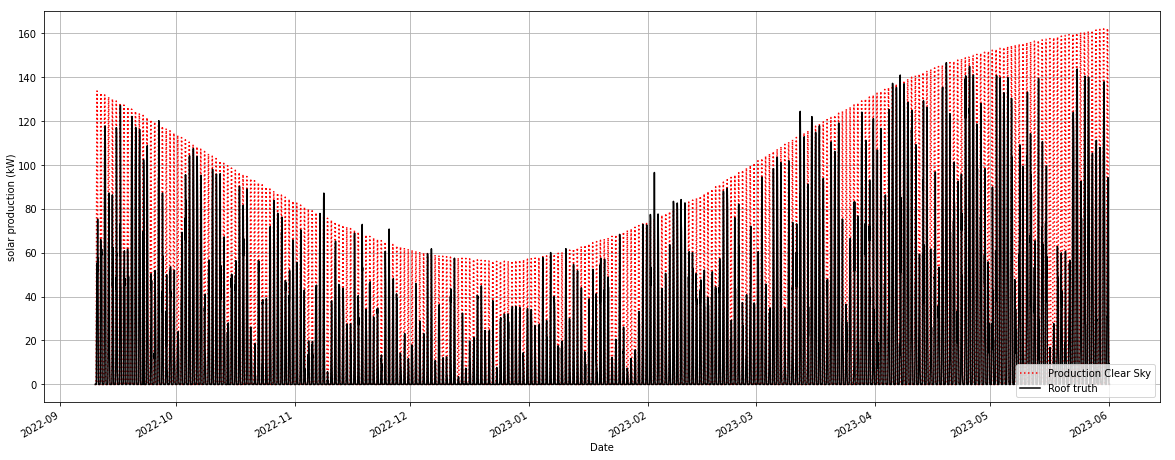

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=1)
styles=['black', 'r:']

ax2 = pred.plot(ax=axes, figsize=(20,8), grid=True, style=styles[1])
ax1 = real.plot(ax=axes, figsize=(20,8), grid=True, style=styles[0])

axes.legend(["Production Clear Sky", "Roof truth"], loc='lower right');

# add a big axes, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.ylabel("solar production (kW)")
plt.savefig('figs/clearsky_real_toit.png')

# Seq2Point

## without nebulosity

In [6]:
df = pd.read_csv('data/prod.csv', parse_dates=['Date'], index_col='Date')
df.index = pd.to_datetime(df.index, format ='%Y-%m-%d %H:%M:%S%z') 
df = df.resample('1H').mean().interpolate(method='time')
df = df.loc[df.index <= '2023-06-01']
real = df[' Production PV toiture instantanee reelle (kW)']

In [7]:
max_, min_ = real.max(), real.min()

In [8]:
real = (real - min_) / (max_ - min_)

In [9]:
X_seq2seq, y_seq2seq = [], []
seq_len = 24
for i in range(seq_len, len(real)):
    X_seq2seq.append(real[i-seq_len:i])
    y_seq2seq.append(real[i])

X_seq2seq = np.array(X_seq2seq)
y_seq2seq = np.array(y_seq2seq)

In [10]:
trainX_seq2seq, trainY_seq2seq = X_seq2seq[:int(len(X_seq2seq)*0.50)], y_seq2seq[:int(len(X_seq2seq)*0.50)]
testX_seq2seq, testY_seq2seq = X_seq2seq[int(len(X_seq2seq)*0.50):], y_seq2seq[int(len(X_seq2seq)*0.50):]

### LSTM

In [11]:
import keras
import tensorflow as tf

In [12]:
model2021 = keras.models.Sequential()
model2021.add(keras.layers.LSTM(128))
model2021.add(keras.layers.Dense(1, activation = 'relu'))
model2021.compile(loss= ['mse'], optimizer= 'rmsprop', metrics= tf.keras.metrics.RootMeanSquaredError())
my_callbacks = tf.keras.callbacks.EarlyStopping(patience=5)

In [13]:
trainX_seq2seq = trainX_seq2seq.reshape((len(trainX_seq2seq), 24, 1))
testX_seq2seq = testX_seq2seq.reshape((len(testX_seq2seq), 24, 1))

In [14]:
start_time = time.time()
history = model2021.fit(trainX_seq2seq, trainY_seq2seq, epochs=100, batch_size=32,validation_split=.2, verbose=0, callbacks=my_callbacks)
print("--- %s seconds ---" % (time.time() - start_time))

--- 24.594114065170288 seconds ---


In [15]:
lstm_predict = model2021.predict(testX_seq2seq)

99/99 [==============================] - 1s 5ms/step


In [16]:
lstm_predict.max()

0.96501124

In [17]:
testScore = np.sqrt(MSE(lstm_predict * max_, testY_seq2seq * max_))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 11.18 RMSE


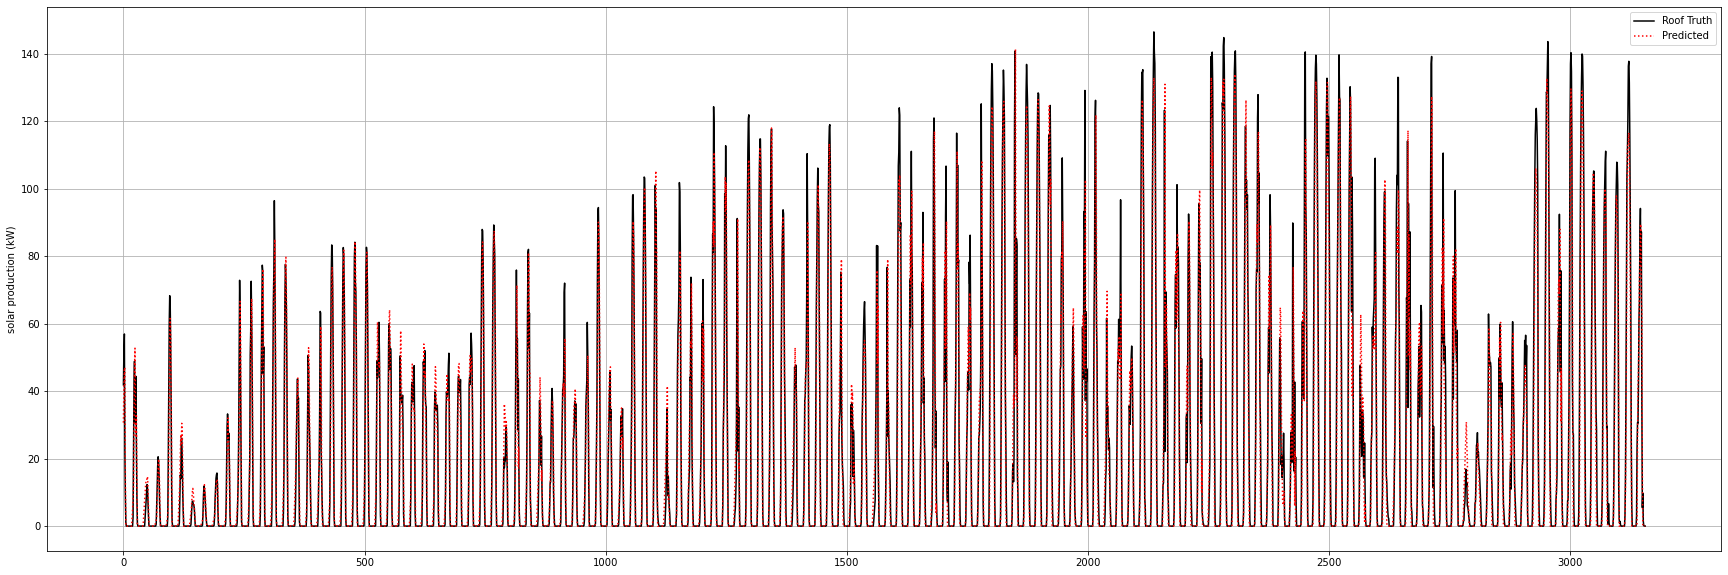

In [18]:
plt.plot(testY_seq2seq * max_, label='Roof Truth', color='black')
plt.plot(lstm_predict * max_, label='Predicted', color='red', linestyle='dotted')
plt.legend()
plt.ylabel('solar production (kW)')
plt.grid(True)
plt.savefig('figs/lstm_hist_roof.png')

In [19]:
'''
fig, axes = plt.subplots(nrows=2, ncols=1)
styles=['b:', 'r:', 'k-']
ax5=dfJoin.plot(ax=axes[0], y=['GHI_Model1','GHI_Model2','Ray_Global_RSR2_Avg'],figsize=(5,8), grid=True, style=styles)
ax5.legend(["GHI forecast","GHI forecast +1d", "Ground truth"], loc='lower right');
styles=['b:', 'r:', 'k-']
ax6=dfJoin.plot(ax=axes[1], y=['DNI_Model1','DNI_Model2','Ray_Direct_RSR2_Avg'],figsize=(5,8), grid=True, style=styles)
ax6.legend(["DNI forecast","DNI forecast +1d", "Ground truth"], loc='lower right');
# add a big axes, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.ylabel("solar radiations (W/m$^2$)")
plt.savefig('8days_forecast.png', dpi=300)
'''

'\nfig, axes = plt.subplots(nrows=2, ncols=1)\nstyles=[\'b:\', \'r:\', \'k-\']\nax5=dfJoin.plot(ax=axes[0], y=[\'GHI_Model1\',\'GHI_Model2\',\'Ray_Global_RSR2_Avg\'],figsize=(5,8), grid=True, style=styles)\nax5.legend(["GHI forecast","GHI forecast +1d", "Ground truth"], loc=\'lower right\');\nstyles=[\'b:\', \'r:\', \'k-\']\nax6=dfJoin.plot(ax=axes[1], y=[\'DNI_Model1\',\'DNI_Model2\',\'Ray_Direct_RSR2_Avg\'],figsize=(5,8), grid=True, style=styles)\nax6.legend(["DNI forecast","DNI forecast +1d", "Ground truth"], loc=\'lower right\');\n# add a big axes, hide frame\nfig.add_subplot(111, frameon=False)\n# hide tick and tick label of the big axes\nplt.tick_params(labelcolor=\'none\', top=False, bottom=False, left=False, right=False)\nplt.grid(False)\nplt.ylabel("solar radiations (W/m$^2$)")\nplt.savefig(\'8days_forecast.png\', dpi=300)\n'

# with nebulosity

In [33]:
neb = pd.read_csv('data/neb.csv', sep=',', parse_dates=['Date'], index_col='Date')

In [34]:
neb_array = neb.to_numpy() / 100

In [35]:
df = pd.read_csv('data/prod.csv', parse_dates=['Date'], index_col='Date')
df.index = pd.to_datetime(df.index, format ='%Y-%m-%d %H:%M:%S%z') 
df = df.resample('1H').mean().interpolate(method='time')
df = df.loc[df.index <= '2023-06-01']
real = df[' Production PV toiture instantanee reelle (kW)'].iloc[:-1]

In [36]:
max_, min_ = real.max(), real.min()

In [37]:
real = (real - real.min()) / (real.max() - real.min())

In [38]:
X_seq2seq, y_seq2seq = [], []
seq_len = 24
for i in range(seq_len, len(real)):
    tmp = real[i-seq_len:i].to_list()
    tmp.append(neb_array[i][0])
    X_seq2seq.append(tmp)
    y_seq2seq.append(real[i])

X_seq2seq = np.array(X_seq2seq)
y_seq2seq = np.array(y_seq2seq)

In [39]:
trainX_seq2seq, trainY_seq2seq = X_seq2seq[:int(len(X_seq2seq)*0.50)], y_seq2seq[:int(len(X_seq2seq)*0.50)]
testX_seq2seq, testY_seq2seq = X_seq2seq[int(len(X_seq2seq)*0.50):], y_seq2seq[int(len(X_seq2seq)*0.50):]

### LSTM

In [40]:
model2021 = keras.models.Sequential()
model2021.add(keras.layers.LSTM(128))
model2021.add(keras.layers.Dense(1, activation = 'relu'))
model2021.compile(loss= ['mse'], optimizer= 'rmsprop', metrics= tf.keras.metrics.RootMeanSquaredError())
my_callbacks = tf.keras.callbacks.EarlyStopping(patience=5)

In [41]:
trainX_seq2seq = trainX_seq2seq.reshape((len(trainX_seq2seq), 25, 1))
testX_seq2seq = testX_seq2seq.reshape((len(testX_seq2seq), 25, 1))

In [42]:
start_time = time.time()
history = model2021.fit(trainX_seq2seq, trainY_seq2seq, epochs=100, batch_size=32,validation_split=.2, verbose=0, callbacks=my_callbacks)
print("--- %s seconds ---" % (time.time() - start_time))

--- 37.918213844299316 seconds ---


In [43]:
lstm_predict = model2021.predict(testX_seq2seq)

99/99 [==============================] - 1s 5ms/step


In [44]:
lstm_predict.max()

0.9410545

In [45]:
testScore = np.sqrt(MSE(lstm_predict * max_, testY_seq2seq * max_))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 11.61 RMSE


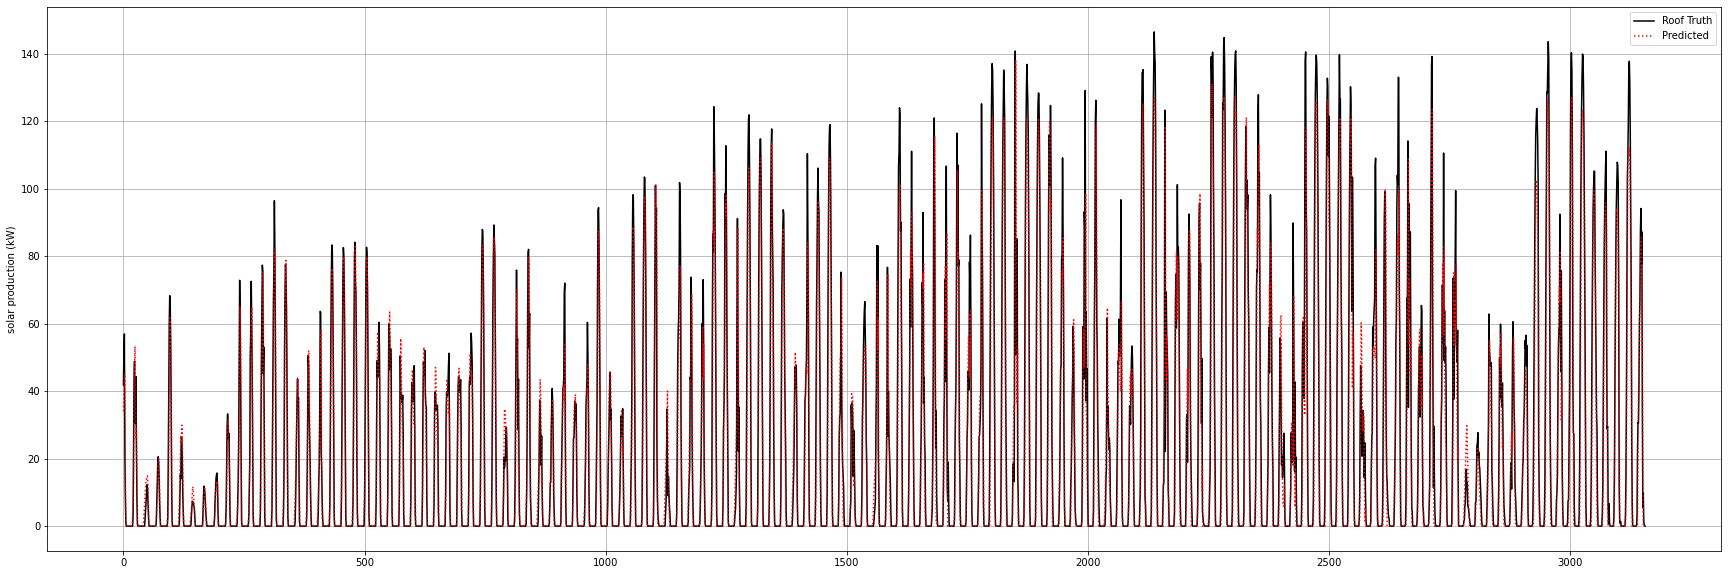

In [46]:
plt.plot(testY_seq2seq * max_, label='Roof Truth', color='black')
plt.plot(lstm_predict * max_, label='Predicted', color='red', linestyle='dotted')
plt.legend()
plt.ylabel('solar production (kW)')
plt.grid(True)
plt.savefig('figs/lstm_hist_neb_toit.png')

# Fit on error

## Without neb

In [59]:
pred = pd.read_csv('data/pred_roof_cs_inverters.csv', parse_dates=['Unnamed: 0'], index_col='Unnamed: 0')
pred.index = pd.to_datetime(pred.index, format ='%Y-%m-%d %H:%M:%S') 
# new = pred.index.tz_localize(None)
# pred.index = new
pred_ = pred.to_numpy()[:-1]

In [60]:

df = pd.read_csv('data/prod.csv', parse_dates=['Date'], index_col='Date')
df.index = pd.to_datetime(df.index, format ='%Y-%m-%d %H:%M:%S%z') 
df = df.loc[df.index <= '2023-06-01']
df = df.resample('1H').mean().interpolate(method='time')
real = df[' Production PV toiture instantanee reelle (kW)'][:-1]


In [61]:
error = pred_.flatten() - real.to_numpy()

In [62]:
max_, min_ = error.max(), error.min()

In [63]:
error = (error - error.min())/(error.max() - error.min())

In [64]:
seq_len = 24
X_test, y_test = [], []
for i in range(seq_len, len(error)):
    tmp = [error[i-seq_len:i].tolist()]
    X_test.append(tmp)
    y_test.append(error[i])

X_test = np.array(X_test)
y_test = np.array(y_test)

trainX_test, trainY_test = X_test[:int(len(X_test)*0.50)], y_test[:int(len(X_test)*0.50)]
testX_test, testY_test = X_test[int(len(X_test)*0.50):], y_test[int(len(X_test)*0.50):]

In [65]:
trainX_test = trainX_test.reshape((len(trainX_test), 24))
testX_test = testX_test.reshape((len(testX_test), 24))

## LSTM

In [66]:
model2021 = keras.models.Sequential()
model2021.add(keras.layers.LSTM(128))
model2021.add(keras.layers.Dense(1, activation = 'relu'))
model2021.compile(loss= ['mse'], optimizer= 'rmsprop', metrics= tf.keras.metrics.RootMeanSquaredError())
my_callbacks = tf.keras.callbacks.EarlyStopping(patience=5)

In [67]:
trainX_test = trainX_test.reshape((len(trainX_test), 24, 1))
testX_test = testX_test.reshape((len(testX_test), 24, 1))

In [68]:
start_time = time.time()
history = model2021.fit(trainX_test, trainY_test, epochs=100, batch_size=32,validation_split=.2, verbose=0, callbacks=my_callbacks)
print("--- %s seconds ---" % (time.time() - start_time))

--- 65.8460488319397 seconds ---


In [69]:
lstm_predict = (model2021.predict(testX_test).flatten() * (max_ - min_)) + min_

99/99 [==============================] - 1s 5ms/step


In [70]:
lstm_predict.max()

121.636

In [71]:
lstm_predict = (pred_[int(len(X_test)*0.50):].flatten()[24:] - lstm_predict)

In [72]:
lstm_predict = np.array([data if data >= 0 else 0 for data in lstm_predict])

In [73]:
testScore = np.sqrt(MSE(lstm_predict, real[int(len(X_test)*0.50):][24:].to_numpy()))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 11.90 RMSE


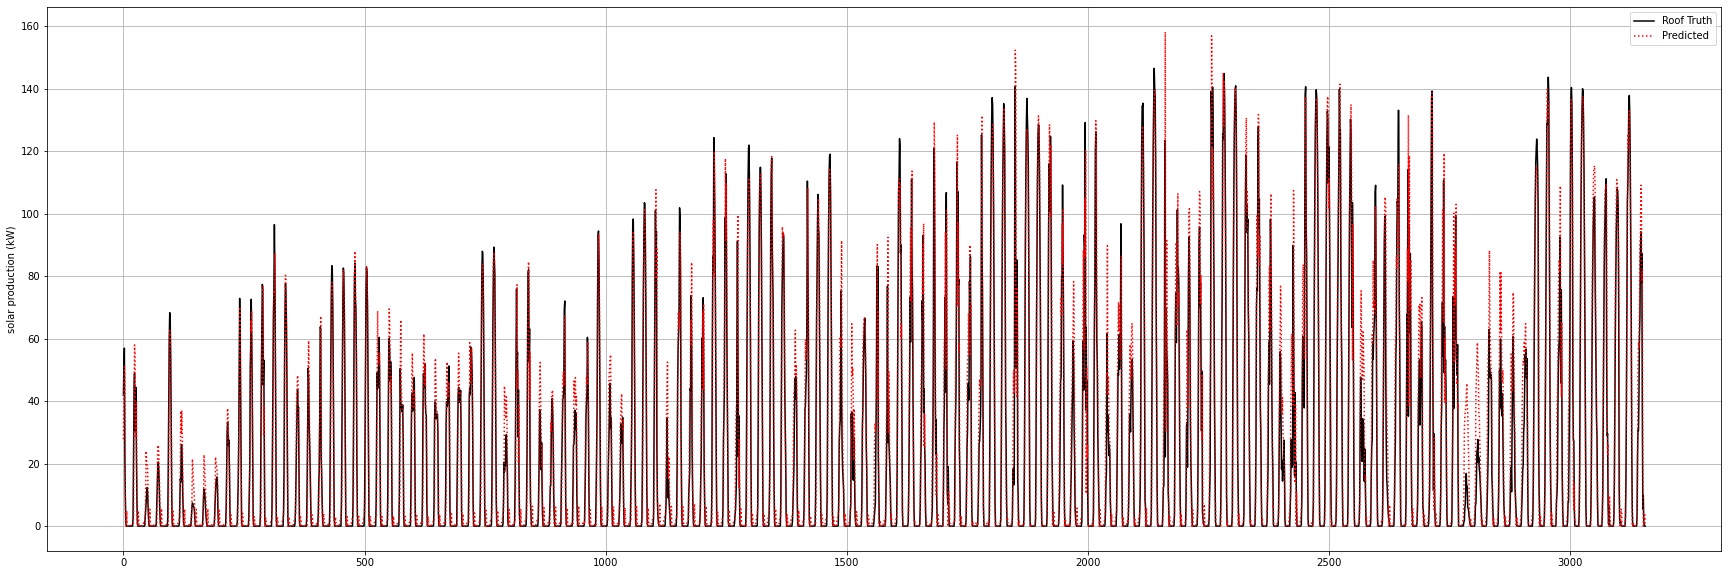

In [74]:
plt.plot(real[int(len(X_test)*0.50):][24:].to_numpy(),  label='Roof Truth', color='black')
plt.plot(lstm_predict,  label='Predicted', color='red', linestyle='dotted')
plt.legend()
plt.ylabel('solar production (kW)')
plt.grid(True)
plt.savefig('figs/lstm_error_hist_toit.png')

# with neb

## LSTM

In [76]:
pred = pd.read_csv('data/pred_roof_cs_inverters.csv', parse_dates=['Unnamed: 0'], index_col='Unnamed: 0')
pred.index = pd.to_datetime(pred.index, format ='%Y-%m-%d %H:%M:%S%z') 
pred_ = pred.to_numpy()[:-1]

In [77]:
neb = pd.read_csv('data/neb.csv', sep=',', parse_dates=['Date'], index_col='Date')
neb_array = neb.to_numpy()/100

In [78]:
df = pd.read_csv('data/prod.csv', parse_dates=['Date'], index_col='Date')
df.index = pd.to_datetime(df.index, format ='%Y-%m-%d %H:%M:%S%z') 
df = df.resample('1H').mean().interpolate(method='time')
df = df.loc[df.index <= '2023-06-01']
real = df[' Production PV toiture instantanee reelle (kW)'].iloc[:-1]


In [79]:

error = pred_.flatten() - real.to_numpy()

max_, min_ = error.max(), error.min()
error = (error - error.min()) / (error.max() - error.min())

In [80]:
X_seq2seq, y_seq2seq = [], []
seq_len = 24
for i in range(seq_len, len(real)):
    tmp = error[i-seq_len:i].tolist()
    tmp.append(neb_array[i][0])
    X_seq2seq.append(tmp)
    y_seq2seq.append(error[i])

X_seq2seq = np.array(X_seq2seq)
y_seq2seq = np.array(y_seq2seq)

In [81]:
trainX_seq2seq, trainY_seq2seq = X_seq2seq[:int(len(X_seq2seq)*0.50)], y_seq2seq[:int(len(X_seq2seq)*0.50)]
testX_seq2seq, testY_seq2seq = X_seq2seq[int(len(X_seq2seq)*0.50):], y_seq2seq[int(len(X_seq2seq)*0.50):]

In [82]:
model2021 = keras.models.Sequential()
model2021.add(keras.layers.LSTM(128))
model2021.add(keras.layers.Dense(1, activation = 'relu'))
model2021.compile(loss= ['mse'], optimizer= 'rmsprop', metrics= tf.keras.metrics.RootMeanSquaredError())
my_callbacks = tf.keras.callbacks.EarlyStopping(patience=5)

In [83]:
trainX_seq2seq = trainX_seq2seq.reshape((len(trainX_seq2seq), 25, 1))
testX_seq2seq = testX_seq2seq.reshape((len(testX_seq2seq), 25, 1))

In [84]:
start_time = time.time()
history = model2021.fit(trainX_seq2seq, trainY_seq2seq, epochs=100, batch_size=32, validation_split=.2, verbose=0, callbacks=my_callbacks)
print("--- %s seconds ---" % (time.time() - start_time))

--- 29.176751852035522 seconds ---


In [85]:
lstm_predict = (model2021.predict(testX_seq2seq).flatten() * (max_ - min_)) + min_

99/99 [==============================] - 1s 5ms/step


In [86]:
lstm_predict.max()

124.92198

In [87]:
lstm_predict = pred_[int(len(X_test)*0.50):].flatten()[24:] - lstm_predict

In [88]:
lstm_predict = np.array([data if data >= 0 else 0 for data in lstm_predict])

In [89]:
testScore = np.sqrt(MSE(lstm_predict, real[int(len(X_test)*0.50):][24:].to_numpy()))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 11.76 RMSE


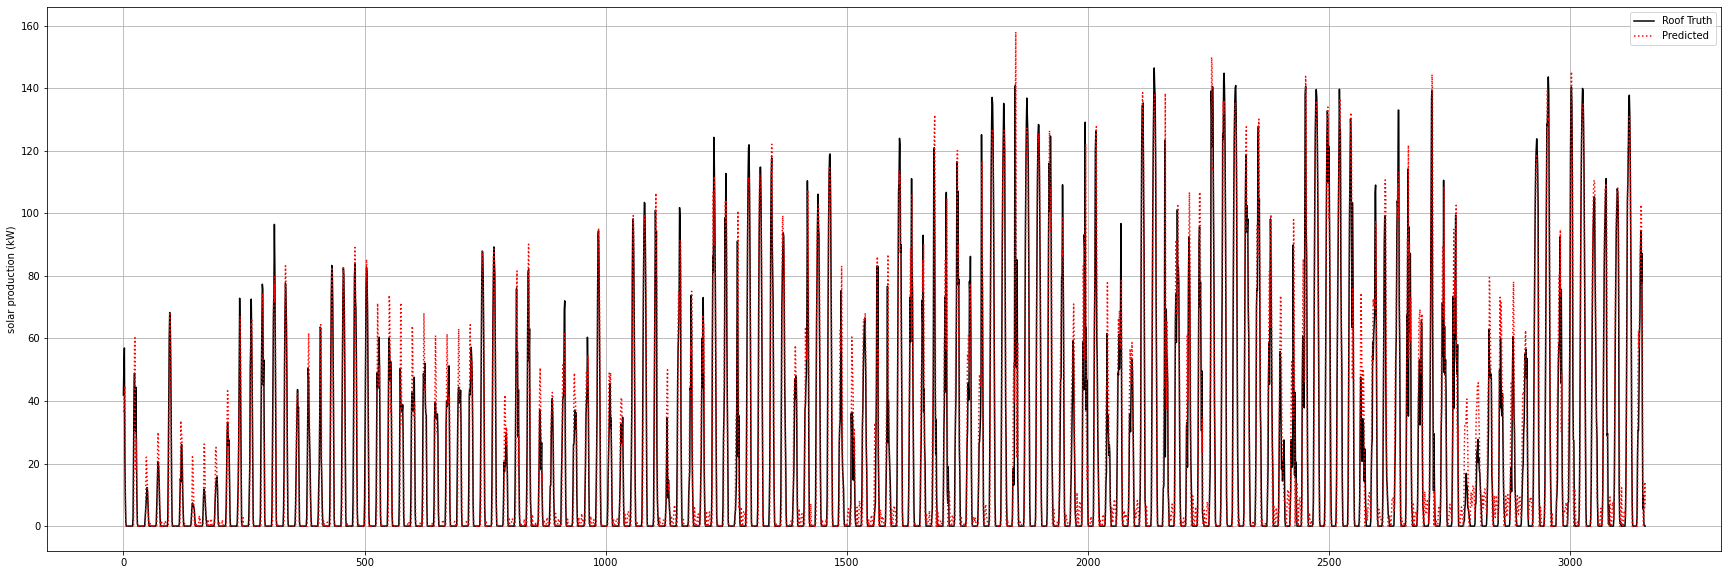

In [90]:
plt.plot(real[int(len(X_test)*0.50):][24:].to_numpy(),  label='Roof Truth', color='black')
plt.plot(lstm_predict,  label='Predicted', color='red', linestyle='dotted')
plt.legend()
plt.ylabel('solar production (kW)')
plt.grid(True)
plt.savefig('figs/lstm_error_hist_neb_toit.png')